In [1]:
import os
import math
import numpy as np
from matplotlib import pyplot as plt

In [18]:
from numpy.random import default_rng
rng = default_rng(seed=123)

# Simulated single-cell Data

- Rough reconstruction of simulated data from psupertime paper
- Based on the beta-cell dataset [Qui2017] with 7 time labels
    - What data is reused/kept?
    - What information is sampled?
- Sampling the latent time $l_{i,j}$ for each time label $i$ and cell $j$
- Roughly we construct 3 different gene expression profiles:
    - Time-series genes (variation of expression in latent time)
    - Sample specific (variation in the mean)
    - non-specific genes (constant)

In [19]:
import pandas as pd
data_dir = "/home/julian/Uni/MasterThesis/data/"

qiu2017_tpm = os.path.join(data_dir, "Qiu2017_raw", "GSE87375_Single_Cell_RNA-seq_Gene_TPM.txt")
qiu_tpm = pd.read_table(qiu2017_tpm, index_col=[0,1], sep="\t")

# Subsample qiu_tpm to make computation feasible
qiu_tpm = qiu_tpm.sample(frac=0.5, axis = 0)

In [20]:
# reduce to beta cells 
beta = qiu_tpm.iloc[:, qiu_tpm.columns.str.startswith("b")]

cells = np.array(beta.columns[2:])
num_cells = len(cells)
num_genes = beta.shape[0]

## Sampling the latent time

First, the time code from is extracted from the column names (cells) and converted to their ordinal numbers starting from 0.

In the next step, the ordinal time labels $i \in {0, ... k}$ are replaced by latent time values $l_i$ sampled from the exponential distribution with rate 0.5: 

$ l_i | l_{i-1} \sim \exp (0.5) + l_{i-1} $

Gaussian noise is added to the latent time values for to allow for cell-to-cell variability:
$ t_c | l_i \sim \mathbf{N}(l_i,1) $

In [21]:
# creates a (sorted) mapping of time_code -> number
k = 7  # Number of different labels in this dataset
num_label_conv = dict(zip(["bE17.5", "bP0", "bP3", "bP9", "bP15", "bP18", "bP60"], range(k)))

time_code_labels = [ x.split("_")[0] for x in cells ]
numeric_labels = np.array([ num_label_conv[x] for x in time_code_labels ])

In [22]:
scale = 2  # inverse of rate => rate = 1/scale

# samples the mean latent time for each time label from the
# exponential distribution with rate 0.5.
# The first mean latent time is set to 0.
latent_time_means = np.concatenate(([0], np.cumsum(rng.exponential(2, k-1))))

latent_time = np.array([ latent_time_means[x] for x in numeric_labels ])

# adding gaussian noise
latent_time = latent_time + rng.normal(loc=0, scale=1, size=len(latent_time))

# scaling to [0,1]
latent_time = (latent_time - np.min(latent_time)) / (np.max(latent_time) - np.min(latent_time))

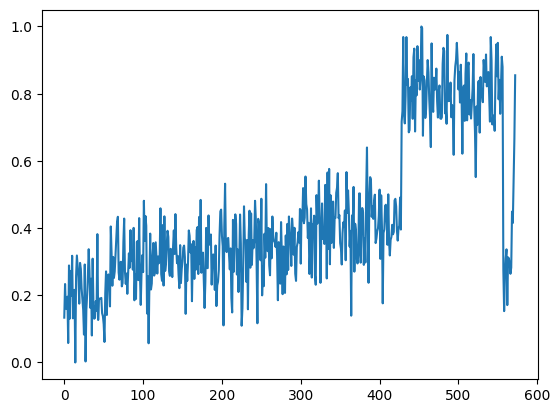

In [23]:
# inspect the sampled labels
# what to expect? -> roughly k "steps"
from matplotlib import pyplot as plt
plt.plot(latent_time)

# Sampling parameters for counts

Randomly sample parameters for creation of count value

##  1. Time-Series Genes

Time series genes have expression values that varies with respect to the latent time values.
The log fold change relative to the mean expression relative to the mean follows a logistic curve.

The logistic curve is defined by the folowing parameters: 
- its midpoint $t_0$
- the half derivative at the midpoint $k$
- and the asymptotic maximum $L$ (measured as total library size for cell = sum of all reads)

Those parameters are sampled below

In [24]:
from numpy.random import default_rng

t0 = rng.uniform(low=0, high=1, size=num_genes)
k = rng.lognormal(mean=1, sigma=1, size=num_genes)
L = rng.gamma(shape=4, scale=0.5, size=num_cells)


In [25]:
def sigmoid(x):
  return 1 / (1 + np.exp(-1 * x))

def sample_time_series_gene(tc, t0, k, L, i=1):
    return L * sigmoid(tc - t0[i]) * k[i] + qiu_tpm.iloc[i].mean()

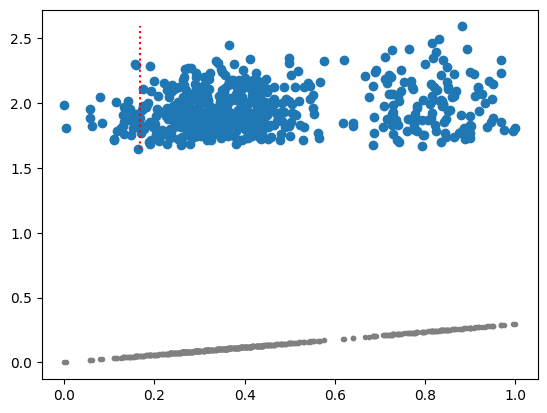

In [26]:
# visualize the time series of an example time series gene

# sample counts for a gene with index i
i = 13
ts_gene_i = sample_time_series_gene(tc=latent_time, t0=t0, k=k, L=L, i=i)

plt.scatter(latent_time, k[i]*latent_time, color="grey", marker=".")
plt.scatter(latent_time, ts_gene_i)
plt.plot([t0[i], t0[i]], [ts_gene_i.min(), ts_gene_i.max()], linestyle="dotted", color="red")

## Label specific genes

The distribution for specific genes is sampled with
- The index of the differentially expressed label
- The fold change at that label

In [27]:
rng = default_rng(seed=321)

# randomly select one label for each gene
de_label = rng.choice(num_cells, size=num_genes, replace=True)

# randomly select the fold change for the chosen labels
fc = rng.gamma(shape=4, scale=0.5, size=num_genes)

## Non-specific genes

Non-specific genes are sampled in the original paper according to:
- gene mean $\mu_g$
- dispersion

Here, we use a simpler dispersion metric, defined for each gene $g$ as:
$$ \bigg(\frac{\sigma^2(g)}{\mu(g)} \bigg)^2 $$

In [28]:
gene_means = qiu_tpm.mean(axis=1)
gene_disp = np.nan_to_num((qiu_tpm.std(axis=1) / gene_means) ** 2)

# Sampling Count Data

In [29]:
simulated_counts = np.zeros(num_cells * num_genes).reshape((num_genes, num_cells))
simulated_counts.shape

(20458, 573)

In [30]:
import anndata as ad
from masterthesis.preprocessing import Preprocessing

for TS_PROP in [0.1, 0.3, 0.5, 0.7, 0.9]:  # proportion of time series genes
    for SS_PROP in [0.1, 0.3, 0.5, 0.7, 0.9]:  # proportion of sample-specific genes
        if TS_PROP + SS_PROP > 1: continue
        
        # Generate the data
        prop = rng.uniform(low=0, high=1, size=num_genes)
        gene_setting = []

        for i in range(len(prop)):
            if prop[i] <= TS_PROP:
                gene_setting.append("TS")
                simulated_counts[i] = L * sigmoid(latent_time - t0[i]) * k[i] + qiu_tpm.iloc[i].mean()
            else:
                simulated_counts[i] = rng.normal(loc=gene_means[i], scale=gene_disp[i], size=num_cells)

                if prop[i] <= SS_PROP:
                    gene_setting.append("SS")
                    simulated_counts[i, de_label[i]] *= fc[i]

                else:
                    gene_setting.append("NS")

        # IMPORTANT post-processing: cut all values lower than zeros, they make no sense as counts
        simulated_counts[ simulated_counts < 0 ] = 0
        
        # Convert to AnnotationData object
        sim_ann = ad.AnnData(simulated_counts.T, dtype=simulated_counts.dtype)

        # assign cell names, time labels (from dataset), and sampled latent time to cells
        sim_ann.obs_names = cells.tolist()
        sim_ann.obs["Time_Labels"] = time_code_labels
        sim_ann.obs["Ordinal_Time_Labels"] = numeric_labels
        sim_ann.obs["Latent_Time"] = latent_time

        # assign gene names and their chosed settings
        sim_ann.var_names = [str(x[0]) for x in beta.index.to_list()]
        sim_ann.var["Setting"] = gene_setting
        
        # Preprocessing
        pp = Preprocessing(log=True, normalize=True, scale=True)
        sim_ann = pp.fit_transform(sim_ann)
        
        # Fix: Add logcounts layer for psupertime to work ...
        sim_ann.layers["logcounts"] = sim_ann.X
        
        # Write out
        filename = 'simdata_TS%s_SS%s.h5ad' % (TS_PROP, SS_PROP)
        sim_ann.write(os.path.join(data_dir, filename))
        print(filename, "written!")

simdata_TS0.1_SS0.1.h5ad written!
simdata_TS0.1_SS0.3.h5ad written!
simdata_TS0.1_SS0.5.h5ad written!
simdata_TS0.1_SS0.7.h5ad written!
simdata_TS0.1_SS0.9.h5ad written!
simdata_TS0.3_SS0.1.h5ad written!
simdata_TS0.3_SS0.3.h5ad written!
simdata_TS0.3_SS0.5.h5ad written!
simdata_TS0.3_SS0.7.h5ad written!
simdata_TS0.5_SS0.1.h5ad written!
simdata_TS0.5_SS0.3.h5ad written!
simdata_TS0.5_SS0.5.h5ad written!
simdata_TS0.7_SS0.1.h5ad written!
simdata_TS0.7_SS0.3.h5ad written!
simdata_TS0.9_SS0.1.h5ad written!
